# TV shows Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the `popularity` of a movie or TV show

<img src="image.jpg" width=300 />




The dataset contains a list of movies and TV shows with the following characteristics:
- `title`: title of the movie in english
- `original_title`: original title of the movie 
- `duration_min`: duration of the movie in minutes
- `popularity`: popularity of the movie in terms of review scores
- `release_date`: release date
- `description`: short summary of the movie
- `budget`: budget spent to produce the movie in USD
- `revenue`: movie revenue in USD 
- `original_language`: original language 
- `status`: is the movie already released or not
- `number_of_awards_won`: number of awards won for the movie
- `number_of_nominations`: number of nominations
- `has_collection`: if the movie is part of a sequel or not
- `all_genres`: genres that described the movie (can be zero, one or many!) 
- `top_countries`: countries where the movie was produced (can be zero, one or many!) 
- `number_of_top_productions`: number of top production companies that produced the film if any. 
Top production companies includes: Warner Bros, Universal Pictures, Paramount Pictures, Canal+, etc...
- `available_in_english`: whether the movie is available in english or not

## Imports

Run the following cell to load the basic packages:

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nbresult import ChallengeResult

In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import SGDRegressor, Lasso
from sklearn.pipeline import Pipeline

In [30]:
from sklearn.model_selection import cross_validate

## Data collection

📝 **Load the `movie_popularity.csv` dataset from the provided this [URL](https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv)**
- First, check and remove the rows that may be complete duplicate from one another (we never know!)
- Then, drop the columns that have too much missing values
- Finally, drop the few remaining rows that have missing values
- Store the result in a `DataFrame` named `data`

In [31]:
!curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv > movie_popularity.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1978k  100 1978k    0     0  1120k      0  0:00:01  0:00:01 --:--:-- 1119k


In [32]:
data_raw = pd.read_csv("movie_popularity.csv")

In [33]:
data_raw.shape

(6864, 17)

Checking duplicates

In [34]:
data_raw.duplicated().value_counts()

False    6464
True      400
dtype: int64

In [35]:
data_raw = data_raw.drop_duplicates()
data_raw.shape

(6464, 17)

Checking missing values

In [36]:
data_raw.isna().sum()*100/data_raw.shape[0]

original_title                0.000000
title                         0.015470
popularity                    0.000000
release_date                  0.000000
duration_min                  0.000000
description                   0.000000
budget                        0.000000
revenue                      59.514233
original_language             0.000000
status                        0.000000
number_of_awards_won          0.000000
number_of_nominations         0.000000
has_collection                0.000000
all_genres                    0.000000
top_countries                 0.000000
number_of_top_productions     0.000000
available_in_english          0.000000
dtype: float64

The **revenue** column is more than half empty. That's sad because it could be a good indicator of popularity... Let's drop it anyways.

In [37]:
data_raw = data_raw.drop(columns="revenue")

In [38]:
data_raw.shape

(6464, 16)

In [39]:
data = data_raw.dropna()
data.shape

(6463, 16)

In [40]:
data.isna().sum()

original_title               0
title                        0
popularity                   0
release_date                 0
duration_min                 0
description                  0
budget                       0
original_language            0
status                       0
number_of_awards_won         0
number_of_nominations        0
has_collection               0
all_genres                   0
top_countries                0
number_of_top_productions    0
available_in_english         0
dtype: int64

### 🧪 Run the following cell to save your results

In [41]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "data_cleaning",
    columns=data.columns,
    cleaning=sum(data.isnull().sum()),
    shape=data.shape)
result.write()

## Baseline model

### The metric

📝 **We want to predict `popularity`: Start by plotting a histogram of the target to visualize it**

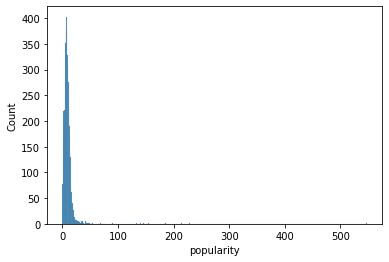

In [42]:
sns.histplot(data.popularity);

📝 **Which sklearn's scoring [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use if we want it to:**

- Be better when greater (i.e. metric_good_model > metric_bad_model)
- Penalize **more** an error between 10 and 20 compared with an error between 110 and 120
- Said otherwise, what matter should be the **relative error ratio**, more than the absolute error difference

Hint: the histogram plotted above should give you some intuition about it

👉 Store its exact [sklearn scoring name](https://scikit-learn.org/stable/modules/model_evaluation.html) as `string` in the variable `scoring` below.

🚨 You must use this metric for the rest of the challenge

In [72]:
# Better when greater : neg
# Penalize more error in smaller ranges : log
scoring = "neg_mean_squared_log_error"

<details>
    <summary>💡 Hint</summary>
It is around here!
<img src="scores.jpg" width=200 height=400 />
</details>

### X,y

**📝 Define `X` as the features Dataframe (keep all features) and `y` as the target Series.**

In [44]:
data.shape

(6463, 16)

In [45]:
X = data.drop(columns="popularity")
X.shape

(6463, 15)

In [46]:
y = data.popularity
y.shape

(6463,)

### Basic pipeline

📝 **Check unique values per features**

In [47]:
X.nunique()

original_title               6350
title                        6337
release_date                 4320
duration_min                  152
description                  6449
budget                        636
original_language              42
status                          3
number_of_awards_won          124
number_of_nominations         180
has_collection                  2
all_genres                    745
top_countries                 320
number_of_top_productions       5
available_in_english            2
dtype: int64

In this baseline, let's forget about the columns below that are difficult to process

In [48]:
text = ['description', 'original_title', 'title']
dates = ['release_date'] 

We will simply scale the numerical features and one-hot-encode the categorical ones remaining

📝 **Prepare 2 `list`s of features names as `str`**:
- `numerical` which contains **only** numerical features
- `categorical` which contains **only** categorical features (exept text and dates above)

In [49]:
X.dtypes

original_title                object
title                         object
release_date                  object
duration_min                 float64
description                   object
budget                         int64
original_language             object
status                        object
number_of_awards_won           int64
number_of_nominations          int64
has_collection                 int64
all_genres                    object
top_countries                 object
number_of_top_productions      int64
available_in_english            bool
dtype: object

In [50]:
# has_collection is encoded as int64 but is actually a boolean, so we put it in categorical
categorical = ['original_language', 'status', 'has_collection', 'all_genres', 'top_countries', 'available_in_english']
numerical = ['duration_min', 'budget', 'number_of_awards_won', 'number_of_nominations', 'number_of_top_productions']

### Pipelining

You are going to build a basic pipeline made of a basic preprocessing and a trees-based model of your choice.

#### Preprocessing pipeline

**📝 Create a basic preprocessing pipeline for the 2 types of features above:**
- It should scale the `numerical` features
- one-hot-encode the `categorical` and `boolean` features
- drop the others
- Store your pipeline in a `basic_preprocessing` variable

In [51]:
# Execute this cell to enable a nice display for your pipelines
from sklearn import set_config

In [53]:
#set_config(display='diagram')

In [54]:
ohe = OneHotEncoder(handle_unknown="ignore")
basic_preprocessing = ColumnTransformer([
    ('num_transformer', RobustScaler(), numerical),
    ('cat_transformer', ohe, categorical)],
    remainder="drop")

**📝 Encode the features and store the result in the variable `X_basic_preprocessing`.**

In [55]:
X_basic_preprocessing = basic_preprocessing.fit_transform(X)
X_basic_preprocessing.shape

(6463, 1119)

**❓ How many features has been generated by the preprocessing? What do you think about this number?**

1119 features have been generated.

This number is very high, especially in regards to the number of observations : as a rule of thumb we should have at least "10 observations per feature", here the ratio is about 6.

This is due to the one-hot-encoding of some categorical variables that have many values. 

#### Modeling pipeline

Let's add a model to our pipe. With so many features one-hot-encoded, we **need a model which can act as a feature selector**

👉 A linear model regularized with L1 penalty is a good starting point.


**📝 Create a `basic_pipeline` which encapsulate the `basic_preprocessing` pipeline + a linear model with a L1 penalty**

- store the resulting pipeline as `basic_pipeline`
- don't fine-tune it


<details>
    <summary>Hints</summary>

Choose your model from the list [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

</details>

In [74]:
basic_pipeline = Pipeline([('basic_preproc', basic_preprocessing), ('basic_model', Lasso())])

### Cross-validated baseline

**📝 Perform a cross-validated evaluation of your baseline model using the metric you defined above. Store the results of this evaluation as an `array` of floating scores in the `basic_scores` variable.**

In [76]:
basic_scores = cross_validate(basic_pipeline, X, y, scoring=scoring, n_jobs=-1)["test_score"]

In [77]:
basic_scores

array([-0.3011096 , -0.32163868, -0.31165017, -0.30197785, -0.33228729])

### 🧪 Save your results

Run the following cell to save your results

In [78]:
ChallengeResult(
    'baseline',
    metric=scoring,
    features=[categorical,numerical],
    preproc=basic_preprocessing,
    preproc_shape=X_basic_preprocessing.shape,
    pipe=basic_pipeline,
    scores=basic_scores
).write()

## Feature engineering

### Time Features


👉 Let's try to improve performance using the feature `release_date`, and especially its `month` and `year`.

ℹ️ If you want to skip this section, you can move directly to the next one: _Advanced categorical features_.

**📝 Complete the custom transformer `TimeFeaturesExtractor` below**

Running
```python
TimeFeaturesExtractor().fit_transform(X[['release_date']])
``` 
should return something like

|    |   month |   year |
|---:|--------:|-------:|
|  0 |       2 |   2015 |
|  1 |       8 |   2004 |
|  2 |      10 |   2014 |
|  3 |       3 |   2012 |
|  4 |       8 |   2012 |


In [90]:
X[["release_date"]].iloc[:,0].apply(lambda x: int(x[5:7]))

0        2
1        8
2       10
3        3
4        8
        ..
6459     8
6460     8
6461    12
6462     2
6463     9
Name: release_date, Length: 6463, dtype: int64

In [91]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    """Extract the 2 time features from a date"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Params:
        X: DataFrame
        y: Series
        
        Returns a DataFrame with 2 columns containing the time features as integers extracted from the release_date.
        """
        df = pd.DataFrame()
        
        # Using iloc to select the first column of X, regardless of its name
        df["month"] = X.iloc[:,0].apply(lambda x: int(x[5:7]))
        df["year"] = X.iloc[:,0].apply(lambda x: int(x[0:4]))
        return df

In [92]:
# Try your transformer and save your new features here
X_time_features = TimeFeaturesExtractor().fit_transform(X[['release_date']])
X_time_features.head()

,month,year
0,2,2015
1,8,2004
2,10,2014
3,3,2012
4,8,2012


We still have 2 problems to solve
- `month` is cyclical: 12 should be a close to 1 as to 11, right? 
- `year` is not scaled

**📝 Build a final custom transformer `CyclicalEncoder` so that**

Running
```python
CyclicalEncoder().fit_transform(X_time_features)
``` 
should return something like this

|    |    month_cos |   month_sin |      year |
|---:|-------------:|------------:|----------:|
|  0 |  0.5         |    0.866025 | 0.0466039 |
|  1 | -0.5         |   -0.866025 | 0.0411502 |
|  2 |  0.5         |   -0.866025 | 0.0461081 |
|  3 |  6.12323e-17 |    1        | 0.0451165 |
|  4 | -0.5         |   -0.866025 | 0.0451165 |

With the cyclical encoding is done as below
- `month_cos = 2 * math.pi / 12 * X[['month']] `
- `month_sin = 2 * math.pi / 12 * X[['month']] `

And the `year` begin min-max scaled

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin
import math

class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclical feature
    """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Compute here what you need for the transform phase and store it as instance variable
        """
        self.min_year = min(X["year"])
        self.max_year = max(X["year"])
        self.std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        return self
        
    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """
        df = pd.DataFrame()
        df["month_cos"] = X["month"].apply(lambda x: np.cos(2 * math.pi / 12 * x))
        df["month_sin"] = X["month"].apply(lambda x: np.sin(2 * math.pi / 12 * x))
        df["year"] = X["year"].apply(lambda x: (x-self.min_year)/(self.max_year-self.min_year))
        return df

In [106]:
# Try your transformer and save your new features here
X_time_cyclical = CyclicalEncoder().fit_transform(X_time_features)
X_time_cyclical.head()

,month_cos,month_sin,year
0,5.000000e-01,0.866025,0.979167
1,-5.000000e-01,-0.866025,0.864583
2,5.000000e-01,-0.866025,0.968750
3,6.123234e-17,1.000000,0.947917
4,-5.000000e-01,-0.866025,0.947917


The scaled year does not look like the one in the example, but the min-max between 0 and 1 seems correct so let's keep it that way.

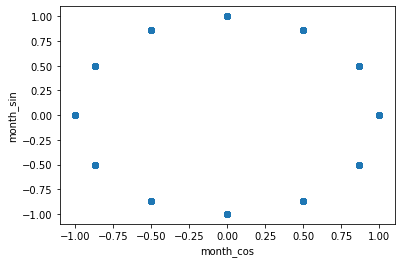

In [107]:
# Check that this form a circle with 12 points
plt.scatter(X_time_cyclical['month_cos'],
            X_time_cyclical['month_sin'])
plt.xlabel("month_cos"); plt.ylabel("month_sin");

**📝 Enhance your `basic_pipeline` with a new preprocessing including both `TimeFeaturesExtractor` and `CyclicalFeatureExtractor`:**

- Just use `TimeFeatureExtractor` if you haven't had time to do the `Cyclical` one
- Store this new pipeline as `time_pipeline`
- Keep same estimator for now

In [129]:
time_preproc = Pipeline([
    ('time_extract', TimeFeaturesExtractor()),
    ('cyclical_encoding', cyclical_encoding),
])

preprocessing = ColumnTransformer([
    ('time_preproc', time_preproc, ["release_date"]),
    ('num_transformer', RobustScaler(), numerical),
    ('cat_transformer', ohe, categorical)],
    remainder="drop")

time_pipeline = Pipeline([
    ('preproc', preprocessing),
    ('basic_model', Lasso())
])

In [131]:
# Just a check
cross_validate(time_pipeline, X, y, scoring=scoring, n_jobs=-1)["test_score"]

array([-0.3011096 , -0.32163868, -0.31165017, -0.30197785, -0.33228729])

### Advanced categorical encoder to reduce the number of features

ℹ️ Most of it has already been coded for you and it shouldn't take long. Still if you want to skip it and move to the next section: _Model Tuning_

👉 We need to reduce the number of features to one-hot-encode, which arise from the high cardinality of `all_genres` and `top_countries`

In [132]:
X[['all_genres', 'top_countries']].nunique()

all_genres       745
top_countries    320
dtype: int64

👇 Both share a common pattern: there can be more than 1 country and more than 1 genre per movie.

In [133]:
X[['all_genres', 'top_countries']].tail()

,all_genres,top_countries
6459,Thriller,"France, United States of America"
6460,"Action, Adventure, Comedy, Thriller",United States of America
6461,Drama,United States of America
6462,"Horror, Thriller",United States of America
6463,Drama,France


👉 Run the cell below where we have coded for you a custom transformer `CustomGenreAndCountryEncoder` which: 
- Select the 10 most frequent genres and the 5 most frequent countries
- Encode `all_genres` into 10 One Hot Encoded features
- Encode `top_countries` into 5 One Hot Encoded features

In [134]:
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

class CustomGenreAndCountryEncoder(BaseEstimator, TransformerMixin):
    """
    Encoding the all_genres and top_companies features which are multi-categorical :
    a movie has several possible genres and countries of productions!
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        compute top genres and top countries of productions from all_genres and top_countries features
        """

        # compute top 10 genres       
        list_of_genres = list(X['all_genres'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(10)]

        # save top_genres in dedicated instance variable
        self.top_genres = top_genres
        
         # compute top 5 countries       
        list_of_countries = list(X['top_countries'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(5)]

        # save top_countries in dedicated instance variable
        self.top_countries = top_countries

        return self

    def transform(self, X, y=None):
        """
        encoding genre and country
        """
        X_new = X.copy()
        for genre in self.top_genres:
            X_new['genre_' + genre] = X_new['all_genres'].apply(lambda x: 1 if genre in x else 0)
        X_new = X_new.drop(columns=["all_genres"])
        for country in self.top_countries:
            X_new['country_' + country] = X_new['top_countries'].apply(lambda x: 1 if country in x else 0)
        X_new = X_new.drop(columns=["top_countries"])
        return X_new

In [135]:
# Check it out
X_custom = CustomGenreAndCountryEncoder().fit_transform(X[['all_genres', 'top_countries']])
print(X_custom.shape)
X_custom.head()

(6463, 15)


,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Adventure,genre_Crime,genre_Science Fiction,genre_Horror,genre_Family,country_United States of America,country_United Kingdom,country_France,country_Germany,country_Canada
0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1


**📝 Compute your `final_pipeline` by integrating all these transformers** (or all those you have coded)

- `CustomGenreAndCountryEncoder`
- `TimeFeaturesExtractor`
- `CyclicalFeatureExtractor`

In [136]:
regular_categorical = ['original_language', 'status', 'has_collection', 'available_in_english']
custom_categorical = ['all_genres', 'top_countries']

final_preprocessing = ColumnTransformer([
    ('time_preproc', time_preproc, ["release_date"]),
    ('num_transformer', RobustScaler(), numerical),
    ('cat_transformer', ohe, regular_categorical),
    ('custom_cat_transformer', CustomGenreAndCountryEncoder(), custom_categorical)],
    remainder="drop")

final_pipeline = Pipeline([
    ('final_preproc', final_preprocessing),
    ('basic_model', Lasso())
])

📝 **Compute and store its cross validated scores as `final_scores` array of floats**

- It does not necessarily improve the performance before we can try-out doing model tuning
- However, with a now limited number of features, we will be able to train more complex models in next section (ensemble...)

In [138]:
final_scores = cross_validate(final_pipeline, X, y, scoring=scoring, n_jobs=-1)["test_score"]

### 🧪 Save your result

Run the following cell to save your results.

In [139]:
ChallengeResult(
    'feature_engineering',
    X_time_features=X_time_features,
    X_time_cyclical= X_time_cyclical,
    time_pipeline=time_pipeline,
    final_pipeline=final_pipeline,
    final_scores=final_scores
).write()

# Hint: Try restarting your notebook if you obtain an error about saving a custom encoder

## Model tuning

### Random Forest

📝 **Change the estimator of your `final_pipeline` by a Random Forest and checkout your new cross-validated score**

In [46]:
# YOUR CODE HERE

### Best hyperparameters quest



**📝 Fine tune your model to try to get the best performance in the minimum amount of time!**

- Store the result of your search inside the `search` variable.
- Store your 5 cross-validated scores inside `best_scores` array of floats

In [47]:
# YOUR CODE HERE

**📝 Re-train your best pipeline on the whole (X,y) dataset**
- Store the trained pipeline inside the `best_pipeline` variable

In [53]:
# YOUR CODE HERE

### Prediction

Now you have your model tuned with the best hyperparameters, you are ready for a prediction.

Here is a famous TV show released in 2017:

```python
dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)
```

**📝 Compute the predicted popularity of this TV show and store it into the `popularity` variable as a floating number.**

In [54]:
# YOUR CODE HERE

In [55]:
# YOUR CODE HERE

### 🧪 Save your results

Run the following cell to save your results.

In [56]:
ChallengeResult(
    "model_tuning",
    search=search,
    best_pipeline=best_pipeline,
    best_scores = best_scores,
    popularity=popularity
).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**